Note: You will need to download this entire folder to your local computer and open it using Anaconda instead of CoCalc.

Import the required packages below (there are a lot):

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string

from collections import Counter

from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Normalizer, StandardScaler

from sklearn.cluster import KMeans

from sklearn import manifold

Let's read in 1507 TMZ celebrity gossip articles collected between 6/9/17 and 8/9/17 and print the first and last one in the list:

In [2]:
article_list = []
with open('data/all_celeb_gossip.txt', 'r') as infile:
    for article in infile:
        article_list.append(article.strip())
        
print(article_list[0])
print()
print(article_list[-1])


DMX went to visit his family ... and he could go to jail as a result.The rapper is out on bail in his tax evasion case, and one of the conditions was that he must give the judge a heads-up if he blows out of town. He left New York to see family in St. Louis, without telling hizzoner ... and that could be a deal breaker.DMX's attorney, Murray Richman, tells TMZ ... it seems like X just forgot, because he was preoccupied with the trip.Richman says X usually notifies his probation officer if he's leaving New York to perform, so this is unlike him. He's guessing the judge will show a little mercy and just up the restrictions -- like requiring an ankle bracelet -- but Richman vows to fight it.Nicholas Biase, a spokesman for the  US attorney for the southern district of NY, tells us X is set to appear in court later this week.

Bill Cosby brought MORE celeb pals to court for day 4 of his sexual assault trial.Cosby walked in with comedian Joe Torry and actor Lewis Dix Jr. Thursday, and the pa

### Topic Clustering

We'll create a pipeline that creates the TF-IDF matrix, calculates the Truncated SVD using the first 50 components, and normalizes it so that all of the components have unit length:

In [3]:
pipe = [('tfidf', TfidfVectorizer(stop_words='english', 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", 
                        min_df=10)),
        ('lsa', TruncatedSVD(n_components=50, random_state=99)),
        ('normalizer', Normalizer())]

pipeline = Pipeline(pipe)
pipeline.fit(article_list)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True...s=50, n_iter=5,
       random_state=99, tol=0.0)), ('normalizer', Normalizer(copy=True, norm='l2'))])

Now, we can get the most important words from each topic:

In [4]:
def print_topic_top_words(pipe, n_topics=10, n_words=5):
    cv = pipe.steps[0][1]
    model = pipe.steps[1][1]
    feature_names = cv.get_feature_names()
    
    for topic_num in range(1,n_topics):
        topic_mat = model.components_[topic_num]
        
        print('Topic {}:'.format(topic_num).center(80))
        
        topic_values = sorted(zip(topic_mat, feature_names), 
                              reverse=True)[:n_words]
        print(' '.join([y for x,y in topic_values]))
        print('-'*80)
        
print_topic_top_words(pipeline)

                                    Topic 1:                                    
chyna rob blac ferrari kardashian
--------------------------------------------------------------------------------
                                    Topic 2:                                    
corinne demario bachelor paradise pool
--------------------------------------------------------------------------------
                                    Topic 3:                                    
trump president donald white prez
--------------------------------------------------------------------------------
                                    Topic 4:                                    
justin bieber tour church purpose
--------------------------------------------------------------------------------
                                    Topic 5:                                    
cops trump chester arrested police
--------------------------------------------------------------------------------
              

Note that the results above make a lot of sense. That summer, Blac Chyna and Rob Kardashian were going through a messy breakup, there was a Bachelor in Paradise sexual assault scandal, President Trump was recently elected, and Justin Bieber was in and out of rehab and trying to find God and on his Purpose World Tour.

We can also try clustering the original data using KMeans unsupervised learning. First, we'll fit our model:

In [5]:
pipeline = Pipeline(pipe)
X = pipeline.fit_transform(article_list)
km = KMeans(n_clusters=10, random_state=99)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=99, tol=0.0001, verbose=0)

For example, what cluster got labeled as 6? It looks like the Bachelor in Paradise sexual assault related articles:

In [6]:
for i in range(len(km.labels_)):
    if km.labels_[i] == 6:
        print(article_list[i])
        print()

Corinne Olympios looked more than willing and fully conscious when she led DeMario Jackson into a pool as they started to hookup while shooting "Bachelor in Paradise."A scene that appears to be part of the controversial incident -- where Corinne essentially claimed sexual assault because she says she was not conscious -- was teased Monday night during the 'Bachelorette' finale. It shows Corinne leading DeMario into the pool in the daylight, with some of her fellow cast members close by ... and cameras rolling.It seems Corinne's speaking coherently and looks very with it ... much like we reported. It's unclear, though, how much time passed between this pool scene and the alleged sexual misconduct. Her legal team says the footage that alarmed a 'BiP' producer -- which eventually shut down production -- took place in a hot tub, not the pool.We've confirmed that's accurate, and Warner Bros. says that hot tub footage will not be aired.

Corinne Olympios was popping pills and mixing booze du

What got labeled as 7? The Rob Kardashian Blac Chyna breakup:

In [7]:
for i in range(len(km.labels_)):
    if km.labels_[i] == 7:
        print(article_list[i])
        print()

Blac Chyna had the cops called on her after Rob's baby mama went ham over a roofer.It happened Tuesday morning at Chyna's L.A. home. She pitched a fit when a guy next door started pitching a roof at 9 AM. We're told Chyna confronted the homeowner, saying it was too damn early to start construction. She said the noise woke up little Dream, and that pissed her off.The neighbor claims Chyna went so ballistic she got scared and called the cops.We're told cops showed up and gave Chyna a free lesson about the law. In L.A., construction can fire up at 7 AM, so the roofer was well within his rights.Chyna calmed down, and cops beat it.

Blac Chyna went from wheels down to wheelchair up at LAX Saturday, and it's unclear why she needed an assist.She can clearly walk, because she got out of the chair at some point and hoofed it to the car.  Our photog didn't ask why she was in the chair, but she probably wouldn't have answered.She was sure mum on a report Rob Kardashian threw shade on her newly-mi

### Clustering Visualizations

Let's also visualize the clusters. We'll visualize the clusters using a TSNE plot. (It may take a while to run because this is computationally intensive). The TSNE plot is a dimensionality reduction technique similar to PCA, but it always produces a 2 dimensional separation, in contrast to PCA which can produce many different components:

In [8]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0,  method='exact')
Y = tsne.fit_transform(X)

If we plotted this as is, then all of the points would be in blue:

Text(0.5, 1.0, 't-SNE')

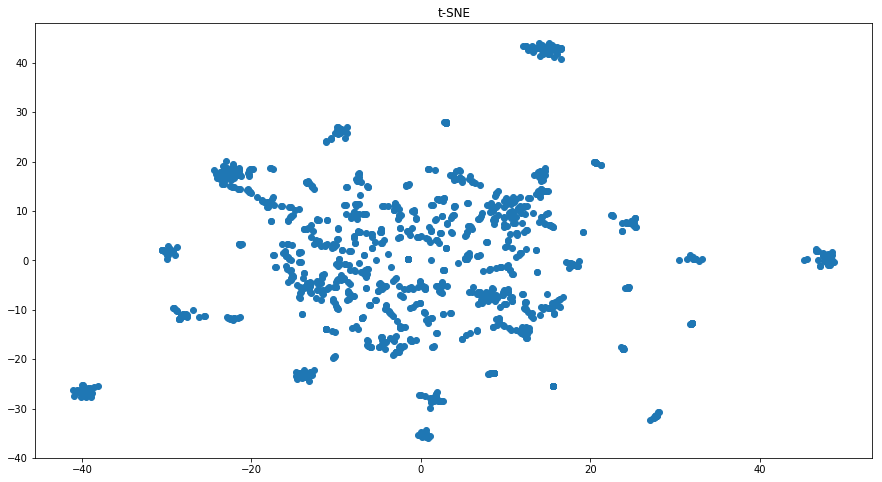

In [9]:
fig = plt.figure(figsize=(15, 8))

plt.scatter(Y[:, 0], Y[:, 1])

plt.title("t-SNE")

We would like different clusters to be labeled different colors. Therefore, we will first create a color key:

In [10]:
color = []
for i in range(len(km.labels_)):
    if km.labels_[i] == 0:
        color.append('orange')
    elif km.labels_[i] == 1:
        color.append('tab:gray') # tab stands for tableau colors - these are other colors built in
    elif km.labels_[i] == 2:
        color.append('tab:olive') 
    elif km.labels_[i] == 3:
        color.append('tab:purple')
    elif km.labels_[i] == 4:
        color.append('tab:red')
    elif km.labels_[i] == 5:
        color.append('tab:green')
    elif km.labels_[i] == 6:
        color.append('tab:blue')
    elif km.labels_[i] == 7:
        color.append('tab:cyan')
    elif km.labels_[i] == 8:
        color.append('k')      
    elif km.labels_[i] == 9:
        color.append('red')        
        

Then, we can apply color coding to our plot:

Text(0.5, 1.0, 't-SNE')

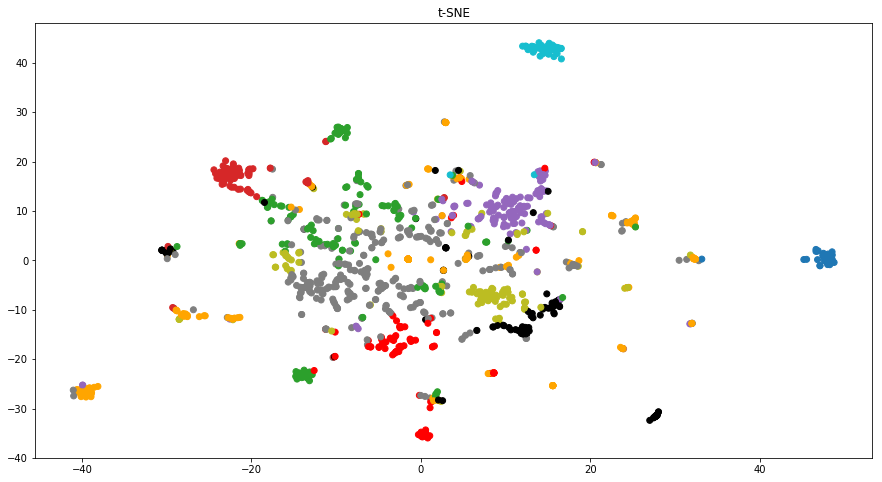

In [11]:
fig = plt.figure(figsize=(15, 8))

plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE")

### d3 scatterplots
On the above plot, it is not easy to see which color corresponds to which set of articles. Let's use d3 to do this instead. [d3](https://d3js.org/) is an extremely powerful tool for doing visualizations. It uses JavaScript which is a language used for web development, but you can usually just copy and paste others' code and just make tiny tweaks in order to plot what you need even if you don't know JavaScript.

First, let's create celeb categories for the articles that contain article themes that we'll be interested in:

In [12]:
celeb_categories = ['other' for i in range(len(article_list))]

for i in range(len(article_list)):
    if any(substring in article_list[i].lower() for substring in ['chyna ', 'ferrari ']):
        celeb_categories[i] = 'rob & chyna'
    elif any(substring in article_list[i].lower() for substring in ['kim ', 'kanye ']):
        celeb_categories[i] = 'kim & kanye'
    elif any(substring in article_list[i].lower() for substring in ['bieb',]):
        celeb_categories[i] = 'justin bieber'
    elif any(substring in article_list[i].lower() for substring in ['trump ', 'president ', 'donald ','prez ', 'scaramucci']):
        celeb_categories[i] = 'trump'
    elif any(substring in article_list[i].lower() for substring in ['corinne ', 'demario ', 'bachelor ']):
        celeb_categories[i] = 'bachelor pool scandal'
    elif any(substring in article_list[i].lower() for substring in ['floyd ', 'conor ' ,'mcgregor ', 'mayweather ']):
        celeb_categories[i] = 'mcgregor mayweather fight'
    elif any(substring in article_list[i].lower() for substring in ['chester ','cornell ' ,'bennington ', 'linkin ']):
        celeb_categories[i] = 'chester & chris cornell suicides'
    elif any(substring in article_list[i].lower() for substring in ['usher ', 'herpes ']):
        celeb_categories[i] = 'usher herpes scandal'
    elif any(substring in article_list[i].lower() for substring in ['cosby ']):
        celeb_categories[i] = 'cosby trial'
    elif any(substring in article_list[i].lower() for substring in ['o.j. ']):
        celeb_categories[i] = 'o.j. simpson'

We can easily view how many of each type of article there are:

In [13]:
Counter(celeb_categories)

Counter({'other': 1090,
         'o.j. simpson': 31,
         'usher herpes scandal': 11,
         'trump': 109,
         'kim & kanye': 55,
         'rob & chyna': 48,
         'bachelor pool scandal': 45,
         'justin bieber': 38,
         'chester & chris cornell suicides': 27,
         'mcgregor mayweather fight': 32,
         'cosby trial': 21})

Then, we'll need to create a csv file of the data that we want to plot. The x and y coordinates will be the same as in the TSNE plot above. We'll also store each x and y point along with its category label and original article. We'll write this DataFrame to a csv file called "d3_scatterplot/celebdata.csv".

In [14]:
xpoints = [Y[i, 0] for i in range(len(article_list))]
ypoints = [Y[i, 1] for i in range(len(article_list))]


df = pd.DataFrame(
    {
    'article': article_list,
    'celeb': celeb_categories,
    'x': xpoints,
    'y': ypoints
    })

df = df[df['celeb']!= 'other']
df.shape
df.to_csv(path_or_buf = 'd3_scatterplot/celebdata.csv', index = False, header = ['article', 'celeb', 'x', 'y'])

Now, open up a new terminal. 

Change directories INTO d3_scatterplot (then type pwd to confirm you are where you should be).

Now type ```python -m http.server``` and press enter. This is making your local computer act as a server (which is needed to view the d3 plot). 

Notice that inside this folder is a file called index.html. 

Your terminal should give some sort of output like ```Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ...``` Open up a web browser and type in that address followed by the index.html name. For example, it will probably be ```http://0.0.0.0:8000/index.html```

You should now see your d3 plot. If you hover over a point, the corresponding article text should pop up. Do some exploring and you will see that the points we color coded ourselves (corresponding to articles containing words like "Cosby", "Kanye", etc.) are clustered together nicely by the TSNE algorithms that was not provided any information from us except for the original corpus of articles. Pretty cool!!! 

You are also able to zoom in and out of the plot. If you'd like to see more of the JavaScript code that is making this super cool plot, open up the scatter.js file that is located within the d3_scatterplot directory.

### d3 Word Clouds

Another type of plot besides a scatterplot that you can create with d3 is a word cloud in which the size of the word is related to the frequency of the word. 

First, we'll create a DataFrame in which each row corresponds to a word and each column corresponds to a 1 if that word appears in a given article number:

In [15]:
cv = CountVectorizer(stop_words='english', 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", 
                        min_df=10, lowercase = False)

X = cv.fit_transform(article_list)

df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
df = df.transpose()
df.index.name = 'word'
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1497,1498,1499,1500,1501,1502,1503,1504,1505,1506
word,,,,,,,,,,,,,,,,,,,,,
AM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Aaron,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
According,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
After,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Air,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will then create a series in that will contain the total frequency count of each word in all the documents:

In [16]:
df['freq'] = df.sum(axis = 1)
df = df[['freq']]
df.head()

,freq
word,
AM,70
Aaron,59
According,108
After,21
Air,12


Upon closer inspection, there are still frequent words left that are kind of boring to put into a word cloud (for example, days of the week and location names). Let's remove these from words that we'll want to plot in our word cloud.

In [17]:
searchfor = ['the', 'he', 'we', 'according','he', 'it', 'as', 'she', 'in', 'thursday', 'monday', 
             'friday', 'saturday', 'they', 'wednesday', 'you', 'sunday', 'tuesday', 'sources', 'white', 
             'but', 'and', 'there', 'our', 'if', 'house', 'that', 'one', 'new', 'june', 'his', 'so', 
             'july', 'when', 'law', 'this', 'park', 'no', 'county', 'not', 'warner', 'august', 'for', 
             'america', 'still', 'london', 'center', 'bros', 'live', 'big', 'san', 'mr', 'april', 'what', 
             'dr', 'ball', 'atlanta', 'now', 'miami', 'city', 'at', 'york', 'on', 'my', 'october', 'here',
             'florida', 'all', 'washington', 'just', 'february', 'march', 'california', 'while', 'however', 
             'state', 'of', 'malibu', 'king', 'jr', 'good', 'georgia',  'after', 'thinks',
            'says', 'told', 'time', 'ca', 'ya', 'got', 'went', 'did', 'far', 'make', 'saying', 'said',
            'want', 'looks', 'including', 'cut', 'gets', 'called','line', 'won',
            'let', 'pm', 'am', 'felt', 'didn', 'wasn', 'left', 'close', 'obtained', 
            'including', 'came', 'close', 'pt', 'em', 'say', 'tells', 've', 'll',
            'don', 'right', 'took', 'tell', 'day', 'near', 'lot', 'com', 'started',
            'clear', 'morning', 'doesn', 'try', 'bit', 'months', 'sent', 'asked',
            'ago', 'week', 'took', 'day', 'days', 'getting', 'know', 'isn', 'wouldn',
            'month', 'think', 'like', 'year', 'wants', 'ran', 'end', 'saw', 'making', 'tried', 'taken', 'saw']

df = df[~df.index.str.lower().isin(searchfor)]
df.head()

,freq
word,
Aaron,59
Air,12
Alex,19
Allen,18
Also,14


We'll also only plot words that occur at least 20 times:

In [18]:
df = df[df['freq'] >= 20]
df.head()

,freq
word,
Aaron,59
Amber,54
American,52
Attorney,20
Awards,22


We'll create a font size column that is related to the frequency of the word:

In [19]:
maxfreq = df['freq'].max()
minfreq = df['freq'].min()

bigsize = 80
smallsize = 20

def font_size(freq):
    size = (freq - minfreq) / (maxfreq-minfreq)
    size = int((size * bigsize) + smallsize)
    return size

df['size'] = df['freq'].apply(font_size)
df.head()

,freq,size
word,,
Aaron,59,26
Amber,54,25
American,52,25
Attorney,20,20
Awards,22,20


Now, we will write this to a file that d3 can use. This is the dataframe that will be stored in the CSV file "d3_wordcloud/frequencies.csv":

In [20]:
df['word'] = df.index
df = df[['word', 'size']]
df.to_csv(path_or_buf = 'd3_wordcloud/frequencies.csv', index = False, header = ['word','size'])
df.head()

,word,size
word,,
Aaron,Aaron,26
Amber,Amber,25
American,American,25
Attorney,Attorney,20
Awards,Awards,20


To view this wordcloud, if you are still in your terminal inside the d3_scatterplot directory, then type ```Control - C``` to stop serving up the scatterplot page. Navigate up one directory and then down into the d3_wordcloud directory: 


```cd ..``` 

```cd d3_wordcloud```

Then, type ``python -m http.server``` once again and open up the webpage ```http://0.0.0.0:8000/index.html```.

### Article Recommendations

Suppose we wanted to recommend users other articles based on articles they like. This should sound familiar to your Netflix work. Once again, we can do an SVD decomposition. Let's use the top 10 most significant latent features and find the 5 most similar articles to the Bachelor scandal below. Are recommendations are spot on!

In [21]:
pipe = [('tfidf', TfidfVectorizer(stop_words='english', 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", 
                        min_df=10)),
        ('lsa', TruncatedSVD(n_components=10, random_state=99)),
        ('normalizer', Normalizer())]

pipeline = Pipeline(pipe)

dtm_svd = pipeline.fit_transform(article_list)

df = pd.DataFrame(dtm_svd.round(10), index=article_list)

def get_article_recs(compare_sentence, df, num_recom):
    recs = []
    for sentence in range(df.shape[0]):
        if sentence != compare_sentence:
            recs.append((np.dot(df.iloc[compare_sentence],df.iloc[sentence]), sentence))
    recs.sort(reverse = True)
    final_rec = [recs[i][1] for i in range(num_recom)]
    for i, rec in enumerate(final_rec):
        print(f"Recommendation #{i+1} {article_list[rec]}\n")
    return final_rec

article_number = 100
num_of_recs = 5
print(f"Top {num_of_recs} articles similar to Article #{article_number}: {article_list[article_number]} \n")
print(f"Article numbers similar to article {article_number}: {get_article_recs(article_number,df,num_of_recs)}")

Top 5 articles similar to Article #100: "Bachelor In Paradise" is hyping a one-on-one showdown between Corinne Olympios and DeMario Jackson, but it will actually be more like Michael Phelps' race against a great white shark.Sources close to production tell us Corinne and DeMario did NOT come face-to-face when the reunion show taped Saturday. While promoting the show, host Chris Harrison has said he'll be talking with both of them together ... insinuating he'd be mediating/refereeing.While fans would eat that up ... it ain't gonna happen. We're told DeMario came out for a solo sit-down with Harrison, but left before Corinne did her one-on-one. We're told neither were briefed on plans to be onstage at the same time.Our DeMario sources tell us he's no longer interested in seeing Corinne face-to-face to hash out the aftermath from their pool sex encounter -- mostly because he doesn't think she would be genuine. 

Recommendation #1 Turns out controversial "Bachelor In Paradise" star DeMario

What about the most similar articles to this Blac Chyna - Rob Kardashian breakup story?

In [22]:
article_number = 22
num_of_recs = 5
print(f"Top {num_of_recs} articles similar to Article #{article_number}: {article_list[article_number]} \n")
print(f"Article numbers similar to article {article_number}: {get_article_recs(article_number,df,num_of_recs)}")


Top 5 articles similar to Article #22: Blac Chyna had the cops called on her after Rob's baby mama went ham over a roofer.It happened Tuesday morning at Chyna's L.A. home. She pitched a fit when a guy next door started pitching a roof at 9 AM. We're told Chyna confronted the homeowner, saying it was too damn early to start construction. She said the noise woke up little Dream, and that pissed her off.The neighbor claims Chyna went so ballistic she got scared and called the cops.We're told cops showed up and gave Chyna a free lesson about the law. In L.A., construction can fire up at 7 AM, so the roofer was well within his rights.Chyna calmed down, and cops beat it. 

Recommendation #1 Rob Kardashian's revenge against Blac Chyna -- posting pics of her vagina and breasts -- would seem to violate the revenge porn law ... but that doesn't seem to be the case.As we reported, Rob believed Chyna was cheating on him and he went on the warpath, not only posting the pics but after they were remo

### Twitter Sentiment Analysis

For our last NLP celebrity application, let's determine who was the most positive and negative celebrity Tweeter. In the summer of 2017, I scraped all of the tweets from the 57 celebs located [here](https://friendorfollow.com/twitter/most-followers/).

In [23]:
import pickle
tweet_list = pd.read_pickle('data/tweet_list.pkl')          #we can read in the pickle file which is similar to reading in a csv
tweet_list['celebrity'] = tweet_list['celebrity'].str.lower()
tweet_list.head()

,celebrity,tweet
0,katyperry,🇦🇺AUSTRALIA🇦🇺 Tickets &amp; VIP packages for n...
1,katyperry,Can’t wait to share the stage with all these a...
2,katyperry,#FBF: Who's getting excited for the #VMAs? 🙋🏼B...
3,katyperry,Auditions kick off on Aug 17 @DisneySprings! 🎤...
4,katyperry,🇦🇺 AUSTRALIA❗Your 1st chance for 🎟 to the new ...


There were 57 celebs and 66,303 total tweets in the dataset:

In [24]:
print(len(set(tweet_list['celebrity'])))
print(tweet_list.shape)

57
(66303, 2)


Tweets contain tons of extra characters and punctuation. Let's use regular expressions to remove these. Don't worry about the code syntax below, just know that it is performing some cleaning:

In [25]:
#group by celeb and calculate their positivity score

#clean up tweets by removing hyperlinks, hashtags, etc.
def remove_mypunct(corpus):

    corpus = map(lambda x: re.sub(r"(#|@|http)\S+", "", x), corpus) #get rid of hashtags 
    corpus = map(lambda x: re.sub(r"(\t|\n|\v|…|“|”)", "", x), corpus) #get rid of whitesape
    corpus = map(lambda x:  re.sub(r"""\w*\d\w*""", ' ', x.lower()), corpus) #get rid of numbers
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    corpus = map(lambda x: punc_re.sub(' ', x), corpus)
    corpus = map(lambda x: re.sub('[\W_]+', " ", x), corpus) #get rid of emojis

    return list(corpus)


Now, we'll go through each celebrity name, clean each tweet, calculate the polarity score of each tweet, and then find the average sentiment score of all of their tweets. We find that Neil Patrick Harris (@actuallynph) is the most positive Tweeter and Snoop Dogg (@snoopdogg) is the most negative Tweeter:

In [26]:
sid = SentimentIntensityAnalyzer()                     # this is the sentiment analyzer we'll use

names = set(tweet_list['celebrity'].values)            # get list of celeb names

sentiment = []                                         # we'll store tuples of sentiment score and celeb name

for name in names:
    celeb_tweets = tweet_list[tweet_list['celebrity'] == name]['tweet']   # get all tweets from given celeb
    cleaned_up_tweets = remove_mypunct(celeb_tweets.values)               # clean up the tweet
    
    compound_scores = []                                    # calculate the sentiment score of each tweet
    for sentence in cleaned_up_tweets:
        ss = sid.polarity_scores(sentence)
        compound_scores.append(float(ss['compound']))
        
    sentiment.append((np.mean(compound_scores), name))     # find the average sentiment score of the given celeb
    
sentiment.sort(reverse = True)                          # sort celeb tuples in decending order of sentiment score

for celeb in sentiment:                                 # print each tuple
    print(celeb)

(0.42542700000000006, 'actuallynph')
(0.3692088407005838, 'louis_tomlinson')
(0.3673526794742164, 'xtina')
(0.35785616666666664, 'theellenshow')
(0.3561306789606035, 'avrillavigne')
(0.3534674728940784, 'khloekardashian')
(0.3452982456140351, 'britneyspears')
(0.3293881567973311, 'cristiano')
(0.3213536666666667, 'billgates')
(0.3125358585858586, 'kevinhart4real')
(0.3025144891122278, 'harry_styles')
(0.30182073578595314, 'jtimberlake')
(0.3015826633165829, 'aliciakeys')
(0.2973490392648287, 'kingjames')
(0.29659799498746864, 'mariahcarey')
(0.2839514595496247, 'oprah')
(0.2808818490245972, 'ladygaga')
(0.2799046861924686, 'taylorswift13')
(0.265298322147651, 'adele')
(0.26399233333333333, 'arianagrande')
(0.2621433222036728, 'ddlovato')
(0.26049095477386935, 'emmawatson')
(0.26023653044203504, 'ryanseacrest')
(0.25517808333333336, 'pitbull')
(0.25230144680851063, 'kyliejenner')
(0.2349787573467674, 'selenagomez')
(0.22746379598662206, 'pink')
(0.2251328607172644, 'aplusk')
(0.22457633

If we wanted to view Snoop Dogg's most negative tweets, we could do so. We see that "hell naw" and "Met gala shit" are two very negative Tweets. However, by saying "Met gala shit" Snoop was probably bragging about being at the Met Gala, so this erroneously got classified as negative. Slang is very hard to classify!!

In [27]:
snoop_tweets = tweet_list[tweet_list['celebrity'] == 'snoopdogg' ]['tweet']

clean_snoop_tweets = remove_mypunct(snoop_tweets.values)

compound_scores = []

for i, sentence in enumerate(clean_snoop_tweets):
        ss = sid.polarity_scores(sentence)
        compound_scores.append((float(ss['compound']), i,sentence))
        
compound_scores.sort()

for i in range(20):
    print(compound_scores[i][0])
    print(snoop_tweets[compound_scores[i][1]])

-0.6808
hell naw 😂 - @MERRYJANE https://t.co/S6Q0swki5a
-0.5859
Wtf?? Explains this 🤷🏾‍♂️🤷🏾‍♂️ https://t.co/uZEvpQGShS https://t.co/seqCqIFTvr
-0.5859
The All Eyez on Me Reviews Are Bullshit | L.A. Weekly https://t.co/jC5ZK3mDc8
-0.5859
Eat a snickers Bitch 🤣 https://t.co/h3SEpooAAN https://t.co/SfJ00b1eNI
-0.5574
Eastside Shit 👏🏾👏🏾💙 https://t.co/TpIBr0SWrD https://t.co/amb30wpUkD
-0.5574
Throwbac Kobe coat finals shit 🔥🔥👏🏾 https://t.co/lEtyRYjBzt https://t.co/Qt3NC45Ap2
-0.5574
Dubs up 90s shit https://t.co/Fz9Yb2T5VR https://t.co/dmwVQAtcbE
-0.5574
Bac on thy sosodef shit 🔥🔥🔥👊🏾 https://t.co/QnDmtOy0UJ https://t.co/cj4BPJK419
-0.5574
Met gala shit 🔥🔥. Empire. Wednesday https://t.co/RuUYimMZhp https://t.co/qkEK1KqFBY
-0.5423
Speed kills 🔥🔥🔥🔥 https://t.co/TA59kDUcNx https://t.co/UlGdseHA5Z
-0.4939
Video comin soon the moment I feared 🔥🔥🔥 https://t.co/8U6eLynspO https://t.co/AqRJjtYCI1
-0.4939
Hi. Haters 👏🏾👏🏾👏🏾🤣 https://t.co/kSiMTL6Cto https://t.co/QhuYXaxKNv
-0.4767
don’t believe the fa

We can also view Neil Patrick Harris' most positive Tweets. Look at his most positive Tweet. It's so saccharine sweet that I almost threw up in mouth a little bit!

In [28]:
neil_tweets = tweet_list[tweet_list['celebrity'] == 'actuallynph' ]['tweet']

clean_neil_tweets = remove_mypunct(neil_tweets.values)

compound_scores = []

for i, sentence in enumerate(clean_neil_tweets):
        ss = sid.polarity_scores(sentence)
        compound_scores.append((float(ss['compound']), i,sentence))
        
compound_scores.sort(reverse = True)

for i in range(20):
    print(compound_scores[i][0])
    print(neil_tweets[compound_scores[i][1]])

0.9765
Happy Mother's Day. I am blessed with an absolutely fantastic mom - wonderful person, doting grandma, beautiful soul. I love her lots. 🌹
0.97
I had the great honor of presenting one of the @CNNHeroes Awards tonight. So inspiring, empowering, amazing. Please watch and support.
0.9636
A heartfelt HAPPY BIRTHDAY to the wonderful @DavidBurtka - the best dad in the world. I'm so glad you were born! http://t.co/KkdWZj0dkK
0.9601
Hope your 2014 is filled with many chapters of adventure, wisdom, and great good times! Happy New Year!!
0.9595
Happy Valentine's Day! Allow the love, find the love, make the love. Not necessarily in that order.
0.9578
It's my best friend @EdAlonzomagic 's birthday! He's awesome and magical and hilarious and deserves a shout out! Happy BD, ED!
0.9571
Excellent time in London seeing @Immersivegatsby. Great cast, great direction, Great Gatsby. Recommended!… https://t.co/DPWNsrnVmU
0.9565
So glad you had fun, mom. @BestTimeEver enjoyed watching you be wowed! Love